# Modelling (AIC)

## 1. Import Libraries

In [1579]:
# Import Libraries


import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from geopandas import GeoDataFrame
import statsmodels.api as sm
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from pysal.model import spreg
from splot.esda import moran_scatterplot
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Type
import sweetviz as sv

import plotly.io as pio
pio.renderers.default='notebook'

In [1580]:
# path definition for each user - please edit to add new users
path_pb = "C:/Users/pauloricardolb/OneDrive - Universidade de Aveiro/TRABALHO_PROJETOS/AP01_ONGOING/POAT/SHARED_Andre"
path_al = "/Users/andresilvalima/Library/CloudStorage/OneDrive-UniversidadedeAveiro/SHARED_Andre"

In [1581]:
# path definition
path = path_al

## 2. Data Preparation for Modelling

### 2.1 Loading and Transforming Datasets

In [1582]:
all_data = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/all_data.piclo")

In [1583]:
# add 1 to AL_pc in order to avoid 0 values
all_data['AL_pc_temp']=all_data['AL_pc']+1

In [1584]:
# log transformation of AL_pc
all_data['Log_AL'] = np.log(all_data['AL_pc_temp'])

In [1585]:
# drop unnecessary columns
all_data.drop(columns=['AL_pc_temp'], axis=1,inplace=True)

In [1586]:
# log transformation of Typology
all_data['Log_Typ'] = np.log(all_data['Typology'])

In [1587]:
all_data['Log_AL'].describe()

count    9018.000000
mean        0.026179
std         0.096603
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.997924
Name: Log_AL, dtype: float64

In [1588]:
all_data['Log_Typ'].describe()

count      9018.0
mean     1.209507
std       0.33387
min           0.0
25%      1.098612
50%      1.098612
75%      1.386294
max       1.94591
Name: Log_Typ, dtype: Float64

In [1589]:
all_data.head()

ID  Nature  Typology  Status     Price   Log_P_A      A  Year   
0  268352       2         5       1  224500.0  6.463698  350.0  2008  \
1  295929       1         4       3  137000.0  6.851002  145.0  2008   
2  259211       1         3       1  193000.0  6.966439  182.0  2008   
3  259235       2         5       4  374000.0  6.840547  400.0  2008   
4  259228       1         2       1   91500.0  7.080289   77.0  2008   

   Cluster_new  NrUtentes  AL_pc  T  Log_AL   Log_Typ  
0            9        0.0    0.0  0     0.0  1.609438  
1           45        0.0    0.0  0     0.0  1.386294  
2           19        0.0    0.0  0     0.0  1.098612  
3           48        0.0    0.0  0     0.0  1.609438  
4           19        0.0    0.0  0     0.0  0.693147

In [1590]:
all_data.shape

(9018, 14)

In [1591]:
all_data['T'].value_counts()

T
0    7241
1    1777
Name: count, dtype: int64

### 2.2 Bring New Cluster Labels to the main datasets

In [1592]:
clusters = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_clusters_2.piclo")

In [1593]:
clusters.head()

Cluster_new                                           geometry      area   
0            1  POLYGON ((-43858.268 105485.133, -43926.607 10...  0.036101  \
1            2  POLYGON ((-41894.818 101023.152, -41985.704 10...  0.023841   
2            3  POLYGON ((-43381.069 106148.686, -43381.861 10...  0.024286   
3            4  POLYGON ((-42925.331 103598.712, -42932.138 10...  0.142291   
4            5  POLYGON ((-42665.937 104985.157, -42696.042 10...  0.141979   

    PCA_h_1   PCA_h_2   PCA_h_3   PCA_h_4   PCA_h_5   PCA_h_6   PCA_h_7  ...   
0 -1.089350 -0.220396  0.327666  0.486717  0.093667  1.268302  0.401024  ...  \
1 -1.908428  0.098360 -0.043268 -0.013403 -0.705910  0.229802  0.116456  ...   
2  4.071759 -2.631850 -2.454731 -1.402054  0.647511 -1.903904 -0.304025  ...   
3 -1.847645  0.076802  0.727929  0.323953  0.126725  0.193189  0.124968  ...   
4  0.058212  0.421190  0.915971 -0.866360 -1.606856  0.028771  0.010300  ...   

   PCA_p_10  Zona_Ward  Zona_Ward_Queen  tot_cs  tot_py  tot_min  Zona_Maxp   
0 -0.405767          4                2   154.0     NaN    154.0          1  \
1  0.163015          4                2   119.0     6.0      6.0          7   
2 -0.045294          4                2    67.0     4.0      4.0          2   
3 -0.182643          4                2   118.0    32.0     32.0          1   
4  0.064562          4                2   146.0    34.0     34.0          2   

   Zona_SKATER  tot_cs  tot_py  
0            0   154.0     NaN  
1            1   119.0     6.0  
2            0    67.0     4.0  
3            0   118.0    32.0  
4            0   146.0    34.0  

[5 rows x 33 columns]

In [1594]:
# merge dwelling data with clusters data
all_data=all_data.merge(clusters, on='Cluster_new', how='left')

In [1595]:
all_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4',
       'PCA_h_5', 'PCA_h_6', 'PCA_h_7', 'PCA_h_8', 'PCA_h_9', 'PCA_h_10',
       'PCA_h_11', 'PCA_p_1', 'PCA_p_2', 'PCA_p_3', 'PCA_p_4', 'PCA_p_5',
       'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'Zona_Ward',
       'Zona_Ward_Queen', 'tot_cs', 'tot_py', 'tot_min', 'Zona_Maxp',
       'Zona_SKATER', 'tot_cs', 'tot_py'],
      dtype='object')

In [1596]:
# drop unnecessary columns
all_data.drop(columns=['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 
                          'PCA_h_4', 'PCA_h_5', 'PCA_h_6','PCA_h_7', 'PCA_h_8', 
                          'PCA_h_9', 'PCA_h_10', 'PCA_h_11',
                          'PCA_p_1', 'PCA_p_2', 'PCA_p_3', 'PCA_p_4', 'PCA_p_5', 
                          'PCA_p_6','PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10',
                          'tot_cs', 'tot_py', 'tot_min'], axis=1,inplace=True)

In [1597]:
# drop dwellings with no lat lon information (geometry)
all_data=all_data[~all_data['geometry'].isna()]

In [1598]:
all_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

In [1599]:
# from the initial 123 clusters, we have now 109 clusters with at least one house from casasapo and primeyield
len(all_data['Cluster_new'].unique())

117

In [1600]:
all_data.dtypes

ID                    Int64
Nature                Int64
Typology              Int64
Status                Int64
Price               float64
Log_P_A             float64
A                   float64
Year                 object
Cluster_new           Int64
NrUtentes           float64
AL_pc               float64
T                     int64
Log_AL              float64
Log_Typ             Float64
geometry           geometry
area                float64
Zona_Ward           float64
Zona_Ward_Queen     float64
Zona_Maxp           float64
Zona_SKATER         float64
dtype: object

In [1601]:
all_data['Year'].value_counts()

Year
2010    2239
2008    1861
2009    1491
2007    1284
2018     769
2020     347
2021     326
2006     261
2022     247
2019      72
2005      28
2023      15
Name: count, dtype: int64

In [1602]:
# convertion of data to float
all_data['Zona_Ward']=np.floor(pd.to_numeric(all_data['Zona_Ward'], errors='coerce')).astype('float64')
all_data['Zona_Ward_Queen']=np.floor(pd.to_numeric(all_data['Zona_Ward_Queen'], errors='coerce')).astype('float64')
all_data['Zona_Maxp']=np.floor(pd.to_numeric(all_data['Zona_Maxp'], errors='coerce')).astype('float64')
all_data['Zona_SKATER']=np.floor(pd.to_numeric(all_data['Zona_SKATER'], errors='coerce')).astype('float64')
all_data['Cluster_new']=np.floor(pd.to_numeric(all_data['Cluster_new'], errors='coerce')).astype('float64')
all_data['Year']=np.floor(pd.to_numeric(all_data['Year'], errors='coerce')).astype('float64')
all_data['Nature']=np.floor(pd.to_numeric(all_data['Nature'], errors='coerce')).astype('float64')
all_data['Typology']=np.floor(pd.to_numeric(all_data['Typology'], errors='coerce')).astype('float64')
all_data['Status']=np.floor(pd.to_numeric(all_data['Status'], errors='coerce')).astype('float64')
all_data['T']=np.floor(pd.to_numeric(all_data['T'], errors='coerce')).astype('float64')

In [1603]:
all_data.dtypes

ID                    Int64
Nature              float64
Typology            float64
Status              float64
Price               float64
Log_P_A             float64
A                   float64
Year                float64
Cluster_new         float64
NrUtentes           float64
AL_pc               float64
T                   float64
Log_AL              float64
Log_Typ             Float64
geometry           geometry
area                float64
Zona_Ward           float64
Zona_Ward_Queen     float64
Zona_Maxp           float64
Zona_SKATER         float64
dtype: object

In [1604]:
all_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

### 2.3 Generate Discriptive Statistics HTML

In [1605]:
# este relatório foi gerado utilizando o sweetviz com o pandas 1.5.3
# para instalar versão 1.5.3, utilizar o anaconda (pip install --upgrade pandas==1.5)
# depois deverá ser atualizado o pandas para a ultima versão (pip install --upgrade pandas)

# my_report = sv.analyze(all_data[['Nature', 'Typology', 'Status', 'Price', 'A', 'Year','AL_pc', 'T']])
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

## 3. Linear Regressions (Aveiro) - SKATER

### 3.1 Data Preparation for DID Linear Regression

In [1606]:
# copy data
spatial_data=all_data.copy()

In [1607]:
plot_spatial_data=spatial_data.copy()

In [1608]:
# transform data to geodataframe
plot_spatial_data=GeoDataFrame(plot_spatial_data, geometry='geometry')

In [1609]:
plot_spatial_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

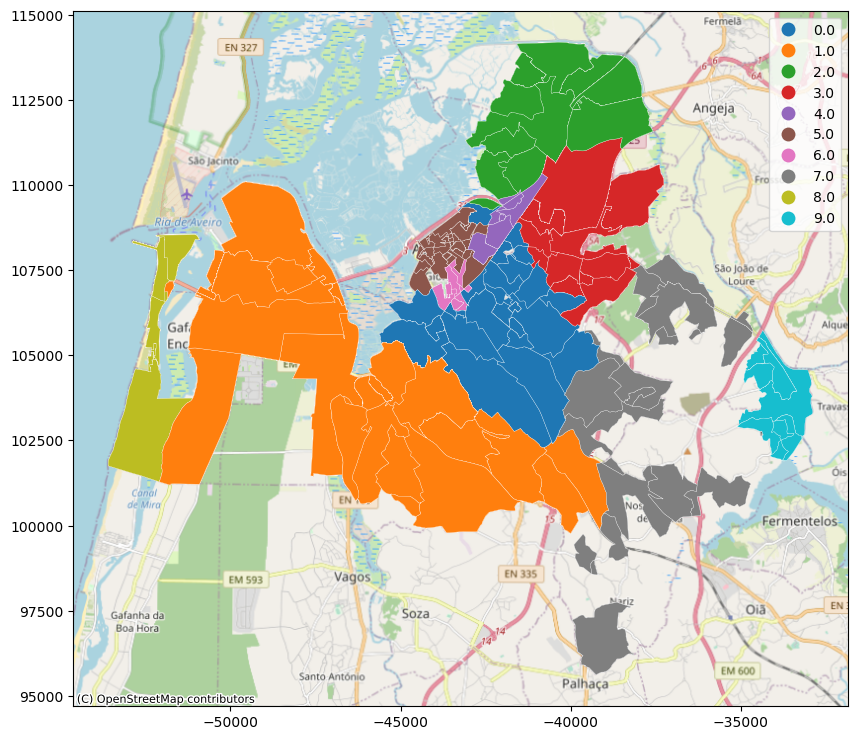

In [1610]:
# view Zona_SKATER clusters
ax=plot_spatial_data.plot(figsize=(10, 10), column="Zona_SKATER", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)


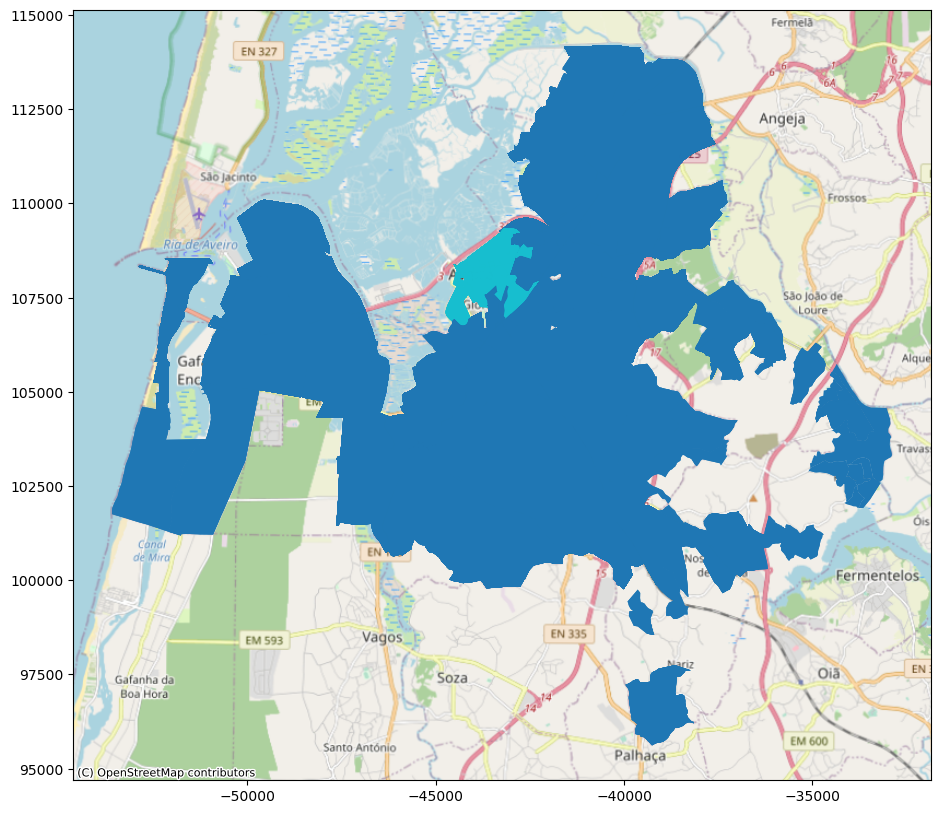

In [1611]:
# view cluster of interest - Aveiro vity center
ax=plot_spatial_data.plot(plot_spatial_data['Zona_SKATER']==5.0,figsize=(20,10))
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [1612]:
plot_spatial_data.head()

ID  Nature  Typology  Status     Price   Log_P_A      A    Year   
0  268352     2.0       5.0     1.0  224500.0  6.463698  350.0  2008.0  \
1  295929     1.0       4.0     3.0  137000.0  6.851002  145.0  2008.0   
2  259211     1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0   
3  259235     2.0       5.0     4.0  374000.0  6.840547  400.0  2008.0   
4  259228     1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0   

   Cluster_new  NrUtentes  AL_pc    T  Log_AL   Log_Typ   
0          9.0        0.0    0.0  0.0     0.0  1.609438  \
1         45.0        0.0    0.0  0.0     0.0  1.386294   
2         19.0        0.0    0.0  0.0     0.0  1.098612   
3         48.0        0.0    0.0  0.0     0.0  1.609438   
4         19.0        0.0    0.0  0.0     0.0  0.693147   

                                            geometry      area  Zona_Ward   
0  POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582        4.0  \
1  POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703        9.0   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
4  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER  
0              4.0        5.0          3.0  
1              2.0        2.0          4.0  
2              3.0        4.0          5.0  
3              1.0        1.0          1.0  
4              3.0        4.0          5.0

In [1613]:
# filter data for Aveiro city center
data_aveiro=spatial_data[spatial_data['Zona_SKATER']==5.0]

In [1614]:
# transform data to geodataframe
data_aveiro=GeoDataFrame(data_aveiro, geometry='geometry')

In [1615]:
data_aveiro.reset_index(drop=True, inplace=True)

In [1616]:
data_aveiro.head()

ID  Nature  Typology  Status     Price   Log_P_A      A    Year   
0  259211     1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0  \
1  259228     1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0   
2  259210     1.0       2.0     1.0   94000.0  7.020233   84.0  2008.0   
3  295932     1.0       4.0     1.0  168100.0  6.957141  160.0  2008.0   
4  259227     1.0       2.0     1.0  100000.0  6.969631   94.0  2008.0   

   Cluster_new  NrUtentes  AL_pc    T  Log_AL   Log_Typ   
0         19.0        0.0    0.0  0.0     0.0  1.098612  \
1         19.0        0.0    0.0  0.0     0.0  0.693147   
2         19.0        0.0    0.0  0.0     0.0  0.693147   
3         19.0        0.0    0.0  0.0     0.0  1.386294   
4         19.0        0.0    0.0  0.0     0.0  0.693147   

                                            geometry      area  Zona_Ward   
0  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0  \
1  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
4  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER  
0              3.0        4.0          5.0  
1              3.0        4.0          5.0  
2              3.0        4.0          5.0  
3              3.0        4.0          5.0  
4              3.0        4.0          5.0

In [1617]:
# check no. of dwellings per cluster in Aveiro Center
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 80, 102 e 106, por escassez de dados

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

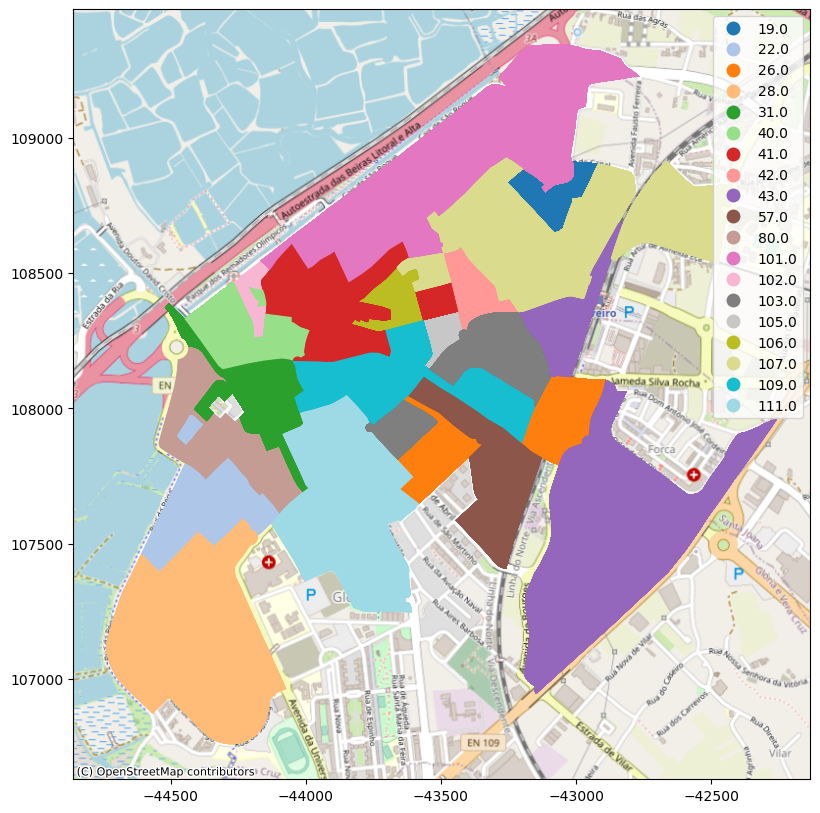

In [1618]:
# view clusters in Aveiro city center
ax=data_aveiro.plot(column=data_aveiro['Cluster_new'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [1619]:
# Area de Intervenção, a ser considerada D = 1 (para SKATER)
lista_D1=[19,40,41,42,101,102,103,105,106,107,109]

In [1620]:
# apply above list to data
data_aveiro['D']=np.where(data_aveiro['Cluster_new'].isin(lista_D1), 1, 0)

In [1621]:
data_aveiro['D'].value_counts()

D
1    1304
0     448
Name: count, dtype: int64

In [1622]:
sum(data_aveiro['D'].value_counts())

1752

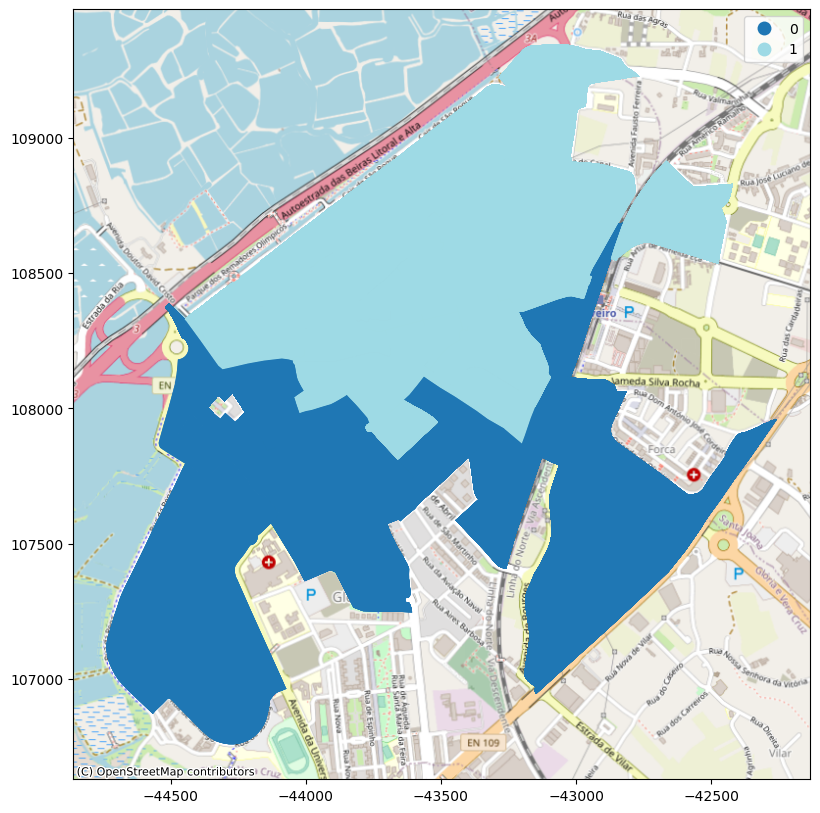

In [1623]:
# check areas defined as control and intervention areas (D=0 and D=1)
ax=data_aveiro.plot(column=data_aveiro['D'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [1624]:
# calculate DT (true when both D and T are equal to 1)
data_aveiro['DT']=data_aveiro['D']*data_aveiro['T']

In [1625]:
# valores do Indice de Preços da Habitação para Aveiro (valores para 21, 22 e 23 são previsões, com base na tendência dos últimos anos)
IPI2005=116.5
IPI2006=110.9
IPI2007=114.3
IPI2008=109.4
IPI2009=103.1
IPI2010=104.4
IPI2018=100.8
IPI2019=114.2
IPI2020=126.2
IPI2021=131.9
IPI2022=133.3
IPI2023=134.6

In [1626]:
# write IPI values to new column
def new_column_value(Year):
    if Year == 2005.0:
        return IPI2005
    elif Year == 2006.0:
        return IPI2006
    elif Year == 2007.0:
        return IPI2007
    elif Year == 2008.0:
        return IPI2008
    elif Year == 2009.0:
        return IPI2009
    elif Year == 2010.0:
        return IPI2010
    elif Year == 2018.0:
        return IPI2018
    elif Year == 2019.0:
        return IPI2019
    elif Year == 2020.0:
        return IPI2020
    elif Year == 2021.0:
        return IPI2021
    elif Year == 2022.0:
        return IPI2022
    elif Year == 2023.0:
        return IPI2023


data_aveiro["IPI"] = data_aveiro["Year"].apply(new_column_value)

In [1627]:
# calculate log of IPI
data_aveiro["Log_IPI"]=np.log(data_aveiro['IPI'])

In [1628]:
# calculate log of Typology
data_aveiro['Log_Typ']=np.log(data_aveiro['Typology'])

In [1629]:
# save data (pickle) bgri
data_aveiro.to_pickle(path+ '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/data_aveiro_SKATER.piclo')

In [1563]:
# get dummies
linreg_center = pd.get_dummies(data_aveiro, columns=['Status','Year','Cluster_new'], drop_first=True, dtype=float)

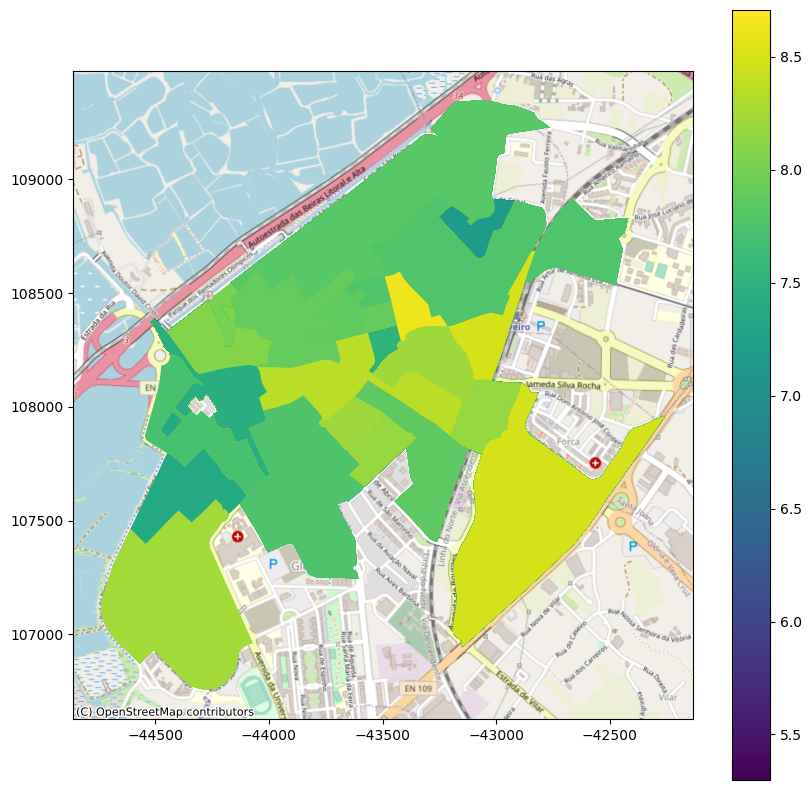

In [1564]:
# check log_P_A distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_P_A'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

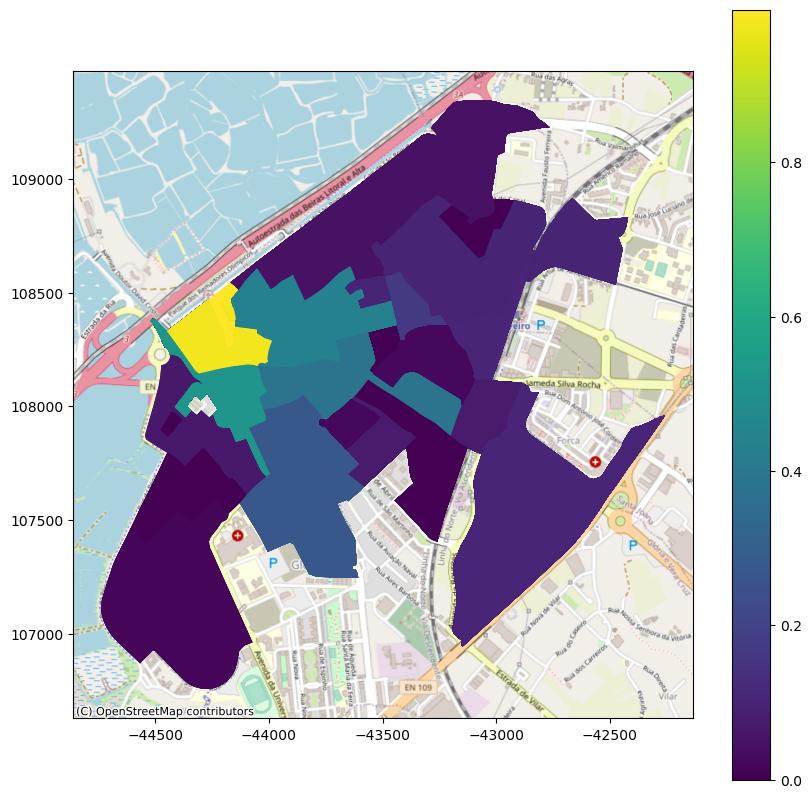

In [1565]:
# check log_AL distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_AL'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

### 3.2 Linear Regression (focused in Aveiro Center - SKATER Cluster)

In [1566]:
linreg_center.columns

Index(['ID', 'Nature', 'Typology', 'Price', 'Log_P_A', 'A', 'NrUtentes',
       'AL_pc', 'T', 'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward',
       'Zona_Ward_Queen', 'Zona_Maxp', 'Zona_SKATER', 'D', 'DT', 'IPI',
       'Log_IPI', 'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Year_2006.0', 'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0', 'Year_2018.0', 'Year_2019.0', 'Year_2020.0',
       'Year_2021.0', 'Year_2022.0', 'Year_2023.0', 'Cluster_new_22.0',
       'Cluster_new_26.0', 'Cluster_new_28.0', 'Cluster_new_31.0',
       'Cluster_new_40.0', 'Cluster_new_41.0', 'Cluster_new_42.0',
       'Cluster_new_43.0', 'Cluster_new_57.0', 'Cluster_new_80.0',
       'Cluster_new_101.0', 'Cluster_new_102.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_106.0', 'Cluster_new_107.0',
       'Cluster_new_109.0', 'Cluster_new_111.0'],
      dtype='object')

In [1567]:
# check number of dwellings per cluster
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

In [1568]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Log_AL',
       'Log_Typ', 'D', 'DT','T', 'Log_IPI', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0']].astype(float)

c_X_eur_area = linreg_center[['DT','D','T',
       'Nature','Log_AL', 'Log_Typ',
       'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Year_2006.0', 'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0','Year_2019.0', 'Year_2020.0',
       'Year_2021.0', 'Year_2022.0',
       'Cluster_new_26.0',
       'Cluster_new_40.0', 'Cluster_new_41.0', 'Cluster_new_42.0',
       'Cluster_new_43.0', 'Cluster_new_57.0',
       'Cluster_new_101.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_107.0',
       'Cluster_new_109.0', 'Cluster_new_111.0']].astype(float)


# menos de 5 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0.
# removido Cluster_new_31.0, Log_IPI, Year_2023, Year_2018 VIF muito alto

In [1569]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

              feature        VIF
0                  DT   7.631760
1                   D  17.266977
2                   T  26.754374
3              Nature  28.148238
4              Log_AL  13.018644
5             Log_Typ  12.876483
6          Status_2.0   2.012921
7          Status_3.0   2.277447
8          Status_4.0   1.507045
9          Status_5.0   2.697939
10        Year_2006.0   2.075593
11        Year_2007.0   8.542829
12        Year_2008.0  10.551243
13        Year_2009.0   7.548273
14        Year_2010.0   9.356913
15        Year_2019.0   2.089381
16        Year_2020.0   1.406358
17        Year_2021.0   1.389308
18        Year_2022.0   1.555528
19   Cluster_new_26.0   1.922769
20   Cluster_new_40.0   2.868922
21   Cluster_new_41.0   1.587205
22   Cluster_new_42.0   1.323659
23   Cluster_new_43.0   1.453559
24   Cluster_new_57.0   1.669946
25  Cluster_new_101.0   2.563434
26  Cluster_new_103.0   2.543750
27  Cluster_new_105.0   1.759492
28  Cluster_new_107.0   2.686017
29  Cluste

In [1570]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.571    
Dependent Variable: Log_P_A          AIC:                -3.4797  
Date:               2023-05-23 13:31 BIC:                171.5127 
No. Observations:   1752             Log-Likelihood:     33.740   
Df Model:           31               F-statistic:        76.33    
Df Residuals:       1720             Prob (F-statistic): 2.88e-296
R-squared:          0.579            Scale:              0.057386 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.7623   0.2434  31.8963 0.0000  7.2850  8.2397
DT                 0.4153   0.0449   9.2398 0.0000  0.3272  0.5035
D                 -0.1056   0.0277  -3.8095 0.0001 -0.1600 -0.0513
T                  0.2991   0.2446   1.2228 0.2216 -0.1807  0.7789
Nature            -0.2058   0.0273  -7.5255 0.0000 -0.2594 -0.1521
Log_AL            -1.0265   0.0993 -10.3386 0.0000 -1.2212 -0.8317
Log_Typ           -0.0833   0.0175  -4.7639 0.0000 -0.1177 -0.0490
Status_2.0        -0.0486   0.0192  -2.5233 0.0117 -0.0863 -0.0108
Status_3.0        -0.1693   0.0171  -9.9251 0.0000 -0.2027 -0.1358
Status_4.0        -0.3098   0.0299 -10.3715 0.0000 -0.3683 -0.2512
Status_5.0         0.0095   0.0201   0.4740 0.6356 -0.0298  0.0488
Year_2006.0       -0.0828   0.2425  -0.3416 0.7327 -0.5585  0.3928
Year_2007.0       -0.1244   0.2407  -0.5170 0.6053 -0.5965  0.3476
Year_2008.0       -0.1360   0.2404  -0.5657 0.5717 -0.6074  0.3355
Year_2009.0       -0.1313   0.2406  -0.5459 0.5852 -0.6031  0.3405
Year_2010.0       -0.1667   0.2403  -0.6935 0.4881 -0.6380  0.3047
Year_2019.0        0.3139   0.0654   4.7968 0.0000  0.1855  0.4422
Year_2020.0        0.2394   0.0376   6.3627 0.0000  0.1656  0.3132
Year_2021.0        0.3434   0.0412   8.3349 0.0000  0.2626  0.4241
Year_2022.0        0.5062   0.0441  11.4914 0.0000  0.4198  0.5926
Cluster_new_26.0  -0.0311   0.0361  -0.8620 0.3888 -0.1020  0.0397
Cluster_new_40.0   0.5198   0.0406  12.8088 0.0000  0.4402  0.5994
Cluster_new_41.0   0.1920   0.0282   6.8206 0.0000  0.1368  0.2472
Cluster_new_42.0  -0.0323   0.0394  -0.8206 0.4120 -0.1095  0.0449
Cluster_new_43.0  -0.0588   0.0463  -1.2697 0.2044 -0.1497  0.0320
Cluster_new_57.0  -0.0513   0.0539  -0.9502 0.3421 -0.1570  0.0545
Cluster_new_101.0 -0.3997   0.0607  -6.5888 0.0000 -0.5186 -0.2807
Cluster_new_103.0 -0.2284   0.0620  -3.6855 0.0002 -0.3500 -0.1069
Cluster_new_105.0  0.1583   0.0315   5.0322 0.0000  0.0966  0.2200
Cluster_new_107.0 -0.4479   0.0529  -8.4606 0.0000 -0.5517 -0.3441
Cluster_new_109.0 -0.0194   0.0665  -0.2917 0.7705 -0.1498  0.1110
Cluster_new_111.0  0.0060   0.0795   0.0750 0.9402 -0.1501  0.1620
------------------------------------------------------------------
Omnibus:              222.785      Durbin-Watson:         1.704   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      2176.325
Skew:                 -0.182       Prob(JB):              0.000   
Kurtosis:             8.448        Condition No.:         234     
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

#### 3.1.a - Diagnostic plots
https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html

In [1571]:
# base code for diagnostic plots

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

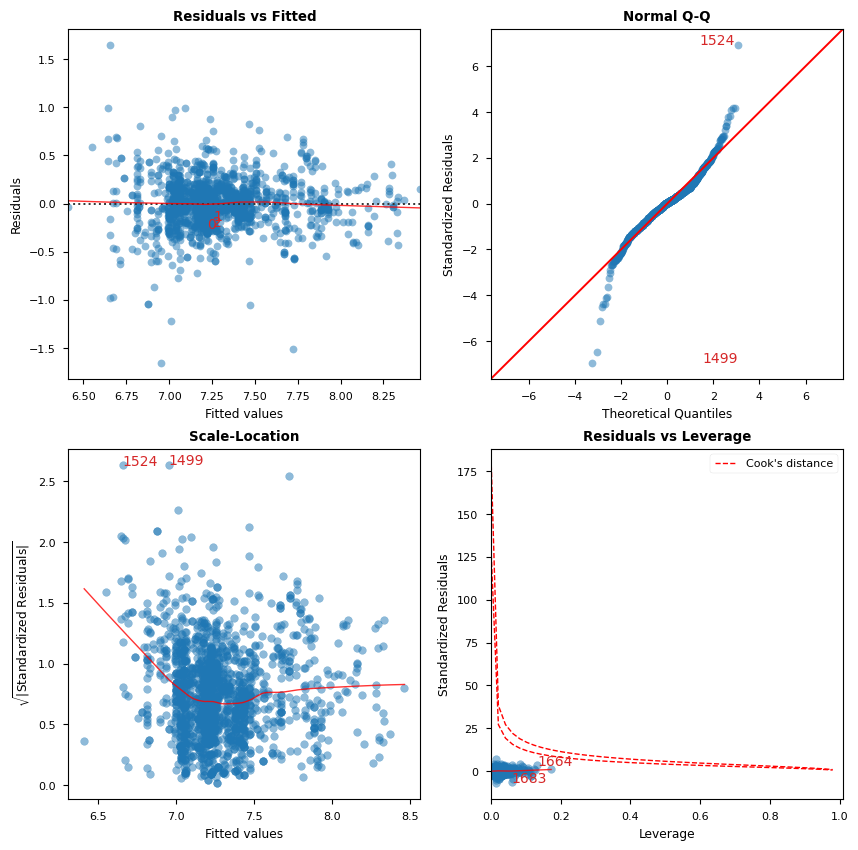

             Features  VIF Factor
31  Cluster_new_111.0        1.10
23   Cluster_new_42.0        1.29
18        Year_2021.0        1.35
17        Year_2020.0        1.36
9          Status_4.0        1.42
24   Cluster_new_43.0        1.43
6             Log_Typ        1.44
22   Cluster_new_41.0        1.48
19        Year_2022.0        1.51
25   Cluster_new_57.0        1.64
28  Cluster_new_105.0        1.66
7          Status_2.0        1.66
8          Status_3.0        1.70
4              Nature        1.72
20   Cluster_new_26.0        1.84
16        Year_2019.0        2.06
10         Status_5.0        2.11
27  Cluster_new_103.0        2.49
30  Cluster_new_109.0        2.49
26  Cluster_new_101.0        2.51
29  Cluster_new_107.0        2.60
21   Cluster_new_40.0        2.71
2                   D        4.47
1                  DT        6.69
5              Log_AL        9.99
11        Year_2006.0       46.87
12        Year_2007.0      224.20
14        Year_2009.0      231.00
15        Year

In [1572]:
# plot diagnostics for the model
cls = Linear_Reg_Diagnostic(results_c_eur_area)
fig, ax = cls()
fig.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/results_c_eur_area_tests_SKATER.png')

#### 3.1.c - Difference in Difference validation

In [1573]:
data_aveiro.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER', 'D', 'DT', 'IPI', 'Log_IPI'],
      dtype='object')

In [1574]:
# copy data for the model (DID validation)
data_aveiro_DID=data_aveiro.copy()

In [1575]:
data_aveiro_DID['Year'].unique()

array([2008., 2005., 2006., 2007., 2009., 2010., 2018., 2019., 2020.,
       2021., 2022., 2023.])

In [1576]:
# define D=1 and D=0
for i in data_aveiro_DID['Year'].unique():
    data_aveiro_DID['Year'+str(i)]=np.where(data_aveiro_DID['Year']==i, data_aveiro_DID['D'],0)

In [1577]:
data_aveiro_DID

ID  Nature  Typology  Status     Price   Log_P_A      A    Year   
0      259211     1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0  \
1      259228     1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0   
2      259210     1.0       2.0     1.0   94000.0  7.020233   84.0  2008.0   
3      295932     1.0       4.0     1.0  168100.0  6.957141  160.0  2008.0   
4      259227     1.0       2.0     1.0  100000.0  6.969631   94.0  2008.0   
...       ...     ...       ...     ...       ...       ...    ...     ...   
1747  1998153     1.0       4.0     1.0  530435.0  8.291104  133.0  2023.0   
1748  1998154     1.0       3.0     1.0  375000.0  8.357344   88.0  2023.0   
1749  1998155     1.0       4.0     1.0  520435.0  8.272071  133.0  2023.0   
1750  1998156     1.0       4.0     1.0  517935.0  8.267256  133.0  2023.0   
1751  1998157     1.0       3.0     1.0  323400.0  8.209308   88.0  2023.0   

      Cluster_new  NrUtentes  ...  Year2006.0  Year2007.0  Year2009.0   
0            19.0        0.0  ...           0           0           0  \
1            19.0        0.0  ...           0           0           0   
2            19.0        0.0  ...           0           0           0   
3            19.0        0.0  ...           0           0           0   
4            19.0        0.0  ...           0           0           0   
...           ...        ...  ...         ...         ...         ...   
1747        103.0       25.0  ...           0           0           0   
1748        103.0       25.0  ...           0           0           0   
1749        103.0       25.0  ...           0           0           0   
1750        103.0       25.0  ...           0           0           0   
1751        103.0       25.0  ...           0           0           0   

      Year2010.0 Year2018.0  Year2019.0  Year2020.0  Year2021.0  Year2022.0   
0              0          0           0           0           0           0  \
1              0          0           0           0           0           0   
2              0          0           0           0           0           0   
3              0          0           0           0           0           0   
4              0          0           0           0           0           0   
...          ...        ...         ...         ...         ...         ...   
1747           0          0           0           0           0           0   
1748           0          0           0           0           0           0   
1749           0          0           0           0           0           0   
1750           0          0           0           0           0           0   
1751           0          0           0           0           0           0   

      Year2023.0  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
1747           1  
1748           1  
1749           1  
1750           1  
1751           1  

[1752 rows x 36 columns]

In [1578]:
# number of dwellings per cluster
pd.pivot_table(data_aveiro_DID, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 102 e 106, por escassez de dados

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

In [1502]:
# get dummies for the DID regression
data_aveiro_DID = pd.get_dummies(data_aveiro_DID, columns=['Status','Year','Cluster_new'], drop_first=True, dtype=float)


In [1503]:
data_aveiro_DID.reset_index(drop=True, inplace=True)

In [1504]:
data_aveiro_DID.columns

Index(['ID', 'Nature', 'Typology', 'Price', 'Log_P_A', 'A', 'NrUtentes',
       'AL_pc', 'T', 'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward',
       'Zona_Ward_Queen', 'Zona_Maxp', 'Zona_SKATER', 'D', 'DT', 'IPI',
       'Log_IPI', 'Year2008.0', 'Year2005.0', 'Year2006.0', 'Year2007.0',
       'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0', 'Year2020.0',
       'Year2021.0', 'Year2022.0', 'Year2023.0', 'Status_2.0', 'Status_3.0',
       'Status_4.0', 'Status_5.0', 'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0', 'Year_2018.0', 'Year_2019.0', 'Year_2020.0',
       'Year_2021.0', 'Year_2022.0', 'Year_2023.0', 'Cluster_new_22.0',
       'Cluster_new_26.0', 'Cluster_new_28.0', 'Cluster_new_31.0',
       'Cluster_new_40.0', 'Cluster_new_41.0', 'Cluster_new_42.0',
       'Cluster_new_43.0', 'Cluster_new_57.0', 'Cluster_new_80.0',
       'Cluster_new_101.0', 'Cluster_new_102.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_106.0', 'Cluster_new_

In [1508]:
# define dependent variable and independent variables
DID_y_eur_area  = data_aveiro_DID['Log_P_A'].astype(float)

DID_X_eur_area = data_aveiro_DID[['Year2006.0', 'Year2007.0','Year2008.0', 
       'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0', 'Year2020.0',
       'Year2021.0', 'Year2022.0',
       'Log_AL', 'Log_Typ', 'Nature',
       'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0', 'Year_2020.0',
       'Year_2021.0', 'Year_2022.0', 'Year_2023.0',
       'Cluster_new_26.0','Cluster_new_22.0','Cluster_new_28.0',
       'Cluster_new_40.0', 'Cluster_new_41.0', 'Cluster_new_42.0',
       'Cluster_new_43.0', 'Cluster_new_57.0',
       'Cluster_new_101.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_107.0',
       'Cluster_new_109.0', 'Cluster_new_111.0']].astype(float)

DID_X_eur_area = data_aveiro_DID[['Year2006.0','Year2007.0',
       'Year2008.0', 'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0',
       'Year2020.0', 'Year2021.0', 'Year2022.0', 'Year2023.0','Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_31.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0','Log_AL', 
       'Log_Typ','Log_IPI','Nature','Status_2.0', 'Status_3.0', 
       'Status_4.0', 'Status_5.0']].astype(float)


# menos de 5 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0.
# removido Cluster_new_31.0, Log_IPI, Year_2023, Year_2018 VIF muito alto
#  ,

# dummy com poucas observações (1) não incluídas (102, 106)
# removido Cluster_new_31.0, e Log_IPI, VIF muito alto

In [1509]:
# calculate VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = DID_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(DID_X_eur_area.values, i)
                          for i in range(len(DID_X_eur_area.columns))]

print(vif_data)

              feature          VIF
0          Year2006.0   348.616666
1          Year2007.0  2366.130365
2          Year2008.0  3340.765368
3          Year2009.0  1936.995721
4          Year2010.0  2682.923464
5          Year2018.0   798.392519
6          Year2019.0   265.451761
7          Year2020.0   371.695796
8          Year2021.0   314.720274
9          Year2022.0   391.992988
10         Year2023.0    88.397205
11   Cluster_new_22.0    51.985303
12   Cluster_new_26.0   830.386656
13   Cluster_new_28.0    52.511078
14   Cluster_new_31.0  2638.136494
15   Cluster_new_40.0     1.914674
16   Cluster_new_41.0     1.419214
17   Cluster_new_42.0     1.270110
18   Cluster_new_43.0   391.830153
19   Cluster_new_57.0   328.313631
20   Cluster_new_80.0    22.506998
21  Cluster_new_101.0     2.433625
22  Cluster_new_103.0     2.875160
23  Cluster_new_105.0     1.715324
24  Cluster_new_107.0     2.403395
25  Cluster_new_109.0     2.627996
26  Cluster_new_111.0    99.737745
27             Log_A

In [1510]:
# run the model
DID_X_eur_area = sm.add_constant(DID_X_eur_area.astype(float))
model_DID_eur_area = sm.OLS(DID_y_eur_area, DID_X_eur_area)
results_DID_eur_area = model_DID_eur_area.fit()
results_DID_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.567    
Dependent Variable: Log_P_A          AIC:                19.1319  
Date:               2023-05-23 13:30 BIC:                210.5099 
No. Observations:   1751             Log-Likelihood:     25.434   
Df Model:           34               F-statistic:        68.37    
Df Residuals:       1716             Prob (F-statistic): 5.35e-290
R-squared:          0.575            Scale:              0.058033 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const             -3.3056   0.7285  -4.5373 0.0000 -4.7345 -1.8767
Year2006.0        -0.4688   0.0536  -8.7494 0.0000 -0.5739 -0.3637
Year2007.0        -0.5571   0.0454 -12.2682 0.0000 -0.6461 -0.4680
Year2008.0        -0.4733   0.0376 -12.5955 0.0000 -0.5470 -0.3996
Year2009.0        -0.3423   0.0324 -10.5743 0.0000 -0.4058 -0.2788
Year2010.0        -0.4010   0.0320 -12.5215 0.0000 -0.4638 -0.3382
Year2018.0         0.2928   0.0413   7.0931 0.0000  0.2118  0.3737
Year2019.0         0.1910   0.0813   2.3476 0.0190  0.0314  0.3505
Year2020.0        -0.2361   0.0757  -3.1175 0.0019 -0.3846 -0.0876
Year2021.0        -0.1913   0.0822  -2.3280 0.0200 -0.3525 -0.0301
Year2022.0         0.0353   0.0839   0.4200 0.6745 -0.1294  0.1999
Year2023.0         0.1432   0.1196   1.1974 0.2313 -0.0914  0.3779
Cluster_new_22.0  -0.2886   0.1125  -2.5662 0.0104 -0.5092 -0.0680
Cluster_new_26.0  -0.2887   0.0402  -7.1837 0.0000 -0.3675 -0.2099
Cluster_new_28.0  -0.0457   0.1137  -0.4019 0.6878 -0.2688  0.1774
Cluster_new_31.0  -0.3247   0.0379  -8.5713 0.0000 -0.3990 -0.2504
Cluster_new_40.0   0.2248   0.0343   6.5473 0.0000  0.1574  0.2921
Cluster_new_41.0   0.0927   0.0277   3.3466 0.0008  0.0384  0.1470
Cluster_new_42.0   0.0138   0.0393   0.3518 0.7250 -0.0633  0.0910
Cluster_new_43.0  -0.3375   0.0542  -6.2267 0.0000 -0.4438 -0.2312
Cluster_new_57.0  -0.1514   0.0559  -2.7115 0.0068 -0.2610 -0.0419
Cluster_new_80.0   0.2691   0.1758   1.5305 0.1261 -0.0757  0.6139
Cluster_new_101.0 -0.0855   0.0601  -1.4219 0.1552 -0.2034  0.0324
Cluster_new_103.0  0.0249   0.0670   0.3721 0.7099 -0.1065  0.1563
Cluster_new_105.0  0.1382   0.0322   4.2944 0.0000  0.0751  0.2014
Cluster_new_107.0 -0.1920   0.0512  -3.7516 0.0002 -0.2923 -0.0916
Cluster_new_109.0 -0.0395   0.0686  -0.5762 0.5645 -0.1742  0.0951
Cluster_new_111.0 -0.1303   0.0803  -1.6221 0.1050 -0.2879  0.0273
Log_AL            -0.0309   0.0646  -0.4786 0.6323 -0.1576  0.0958
Log_Typ           -0.1009   0.0177  -5.7094 0.0000 -0.1355 -0.0662
Log_IPI            2.3991   0.1607  14.9307 0.0000  2.0840  2.7143
Nature            -0.1514   0.0279  -5.4203 0.0000 -0.2062 -0.0966
Status_2.0        -0.0413   0.0196  -2.1078 0.0352 -0.0797 -0.0029
Status_3.0        -0.1599   0.0172  -9.3191 0.0000 -0.1935 -0.1262
Status_4.0        -0.2983   0.0305  -9.7690 0.0000 -0.3582 -0.2384
Status_5.0         0.0205   0.0204   1.0073 0.3139 -0.0194  0.0604
------------------------------------------------------------------
Omnibus:          220.406    Durbin-Watson:       1.664           
Prob(Omnibus):    0.000      Jarque-Bera (JB):    2045.343        
Skew:             -0.207     Prob(JB):            0.000           
Kurtosis:         8.279      Condition No.:       2703250555430638
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The smallest eigenvalue is 6.16e-27. This might indicate that
there are strong multicollinearity problems or that the design
matrix is singular.
"""

### 3.2 Spatial Linear Regression (focused in Aveiro Center - SKATER Cluster)

In [ ]:
#Geração da matriz W, a partir do subset, usando a de matriz de contiguidade Queen
w_Queen = weights.contiguity.Queen.from_dataframe(data_aveiro)
# Standardização das linhas
w_Queen.transform = 'R'

In [ ]:
ax=data_aveiro.plot(column='Cluster_new',categorical=True, legend=True, figsize=(10,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# copy data for the model (spatial reg)
spatial_reg=data_aveiro.copy()

In [ ]:
spatial_reg.columns

In [ ]:
# get dummies for the spatial regression
spatial_reg = pd.get_dummies(spatial_reg, columns=['Status','Cluster_new'], drop_first=True, dtype=float)

In [ ]:
spatial_reg.columns

In [ ]:
# Criação de dataframe com variável dependente, para uso nos modelos (NORTE)
Dep_Var = spatial_reg['Log_P_A'].astype(float)

# Criação de dataframe com variáveis independente, para uso nos modelos (NORTE)
Ind_Var = spatial_reg[['Log_AL',
       'Log_Typ', 'D', 'DT','T', 'Log_IPI', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0']].astype(float)
# apenas 1 caso - 'Cluster_new_106.0','Cluster_new_102.0'
# removido Cluster_new_31.0, VIF muito alto

In [ ]:
# calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = Ind_Var.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Ind_Var.values, i)
                          for i in range(len(Ind_Var.columns))]

print(vif_data)

In [ ]:
# Non-spatial Model (multiple regression)
M_OLS = spreg.OLS(
    Dep_Var.to_numpy(), # Dependent variable
    Ind_Var.to_numpy(), # Independent variable
    name_y = 'Log_P_A', # Dependent variable name
    name_x = list(Ind_Var.columns), #Independent variable name
    w = w_Queen,
    spat_diag=True,
    moran=True,
    name_ds='spatial_reg',
    name_w='w_Queen'
    )

print(M_OLS.summary)

LM error and LM Lag are non significant (0.61 and 0.17), hence we keep OLS as per Elhorst (2010).

## 4. (NOK) Linear Regressions (Ílhavo)

### 4.1 **(NOK)** Linear Regression (focused in Ílhavo Center - SKATER Cluster)

Poucos dados nesta região!!!

In [ ]:
# check SKATER results
ax=plot_spatial_data.plot(figsize=(10, 10), column=plot_spatial_data["Zona_SKATER"], categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# define skater cluster for Ilhavo
data_ilhavo=spatial_data[spatial_data['Zona_SKATER']==1.0]

In [ ]:
# transform to geodataframe
data_ilhavo=GeoDataFrame(data_ilhavo, geometry='geometry')

In [ ]:
data_ilhavo.reset_index(drop=True, inplace=True)

In [ ]:
data_ilhavo.head()

In [ ]:
# no. of dwellings per cluster
pd.pivot_table(data_ilhavo, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

In [ ]:
# check filter results
ax=data_ilhavo.plot(column=data_ilhavo['Cluster_new'],categorical=True, legend=True, figsize=(10,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_ilhavo.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# list of zones to be excluded from the analysis
lista_ilhavo_exclusao=[35,48,50,51,86,118,123,55,81]

In [ ]:
# Area de Intervenção, a ser considerada D = 1
lista_ilhavo_D1=[75,77]

In [ ]:
# apply filter
data_ilhavo=data_ilhavo[~data_ilhavo['Cluster_new'].isin(lista_ilhavo_exclusao)]

In [ ]:
# write D column
data_ilhavo['D']=np.where(data_ilhavo['Cluster_new'].isin(lista_ilhavo_D1), 1, 0)

In [ ]:
# check filtered clusters
ax=data_ilhavo.plot(column=data_ilhavo['Cluster_new'],categorical=True, legend=True, figsize=(20,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_ilhavo.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
data_ilhavo['D'].value_counts()

In [ ]:
# get dummies
linreg_center_ilhavo = pd.get_dummies(data_ilhavo, columns=['Nature', 'Status', 'Year','Cluster_new'], drop_first=True)

In [ ]:
linreg_center_ilhavo.reset_index(drop=True, inplace=True)

In [ ]:
# calculate DT
linreg_center_ilhavo['DT']=linreg_center_ilhavo['D']*linreg_center_ilhavo['T']

In [ ]:
# calculate log Typology
linreg_center_ilhavo['Log_Typ']=np.log(linreg_center_ilhavo['Typology'])

In [ ]:
# number of dwellings per zone
pd.pivot_table(data_ilhavo, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

In [ ]:
linreg_center_ilhavo.columns

In [ ]:
# define X and y
ilhavo_y_eur_area  = linreg_center_ilhavo['Log_P_A'].astype(float)

ilhavo_X_eur_area = linreg_center_ilhavo[['Log_Typ','DT','T','D','Log_AL',
       'Nature_2.0', 'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Year_2006.0', 'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0', 'Cluster_new_33.0',
       'Cluster_new_52.0', 'Cluster_new_53.0', 'Cluster_new_54.0',
       'Cluster_new_56.0', 'Cluster_new_76.0',
       'Cluster_new_78.0', 'Cluster_new_131.0']].astype(float)

# VIF inf removidos

In [ ]:
# calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = ilhavo_X_eur_area.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(ilhavo_X_eur_area.values, i)
                          for i in range(len(ilhavo_X_eur_area.columns))]

print(vif_data)

In [ ]:
# run the model
ilhavo_X_eur_area = sm.add_constant(ilhavo_X_eur_area)
model_ilhavo_eur_area = sm.OLS(ilhavo_y_eur_area, ilhavo_X_eur_area.astype(float))
results_ilhavo_eur_area = model_ilhavo_eur_area.fit()
results_ilhavo_eur_area.summary2()

Temos muito poucos casos para D=1 (97 casos) e D=0 (687 casos). Tendo em conta a heterogenidade de casas (diferentes estados de preservação, tipologia, etc.), 97 casos não é suficiente para fazer uma análise estatística robusta.

## 5. Linear Regressions (Aveiro) - MaxP

### 5.1 Data Preparation for DID Linear Regression

In [ ]:
# copy data
spatial_data=all_data.copy()

In [ ]:
plot_spatial_data=spatial_data.copy()

In [ ]:
# transform data to geodataframe
plot_spatial_data=GeoDataFrame(plot_spatial_data, geometry='geometry')

In [ ]:
plot_spatial_data.columns

In [ ]:
# view Zona_Maxp clusters
ax=plot_spatial_data.plot(figsize=(10, 10), column="Zona_Maxp", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)


In [ ]:
# view cluster of interest - Aveiro vity center
ax=plot_spatial_data.plot(plot_spatial_data['Zona_Maxp']==4.0,figsize=(20,10))
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
plot_spatial_data.head()

In [ ]:
# filter data for Aveiro city center
data_aveiro=spatial_data[spatial_data['Zona_Maxp']==4.0]

In [ ]:
# transform data to geodataframe
data_aveiro=GeoDataFrame(data_aveiro, geometry='geometry')

In [ ]:
data_aveiro.reset_index(drop=True, inplace=True)

In [ ]:
data_aveiro.head()

In [ ]:
# check no. of dwellings per cluster in Aveiro Center
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 80, 102 e 106, por escassez de dados

In [ ]:
# view clusters in Aveiro city center
ax=data_aveiro.plot(column=data_aveiro['Cluster_new'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# Area de Intervenção, a ser considerada D = 1 (para SKATER)
lista_D1=[19,40,41,42,101,102,103,105,106,107,109]

In [ ]:
# apply above list to data
data_aveiro['D']=np.where(data_aveiro['Cluster_new'].isin(lista_D1), 1, 0)

In [ ]:
data_aveiro['D'].value_counts()

In [ ]:
sum(data_aveiro['D'].value_counts())

In [ ]:
# check areas defined as control and intervention areas (D=0 and D=1)
ax=data_aveiro.plot(column=data_aveiro['D'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# calculate DT (true when both D and T are equal to 1)
data_aveiro['DT']=data_aveiro['D']*data_aveiro['T']

In [ ]:
# valores do Indice de Preços da Habitação para Aveiro (valores para 21, 22 e 23 são previsões, com base na tendência dos últimos anos)
IPI2005=116.5
IPI2006=110.9
IPI2007=114.3
IPI2008=109.4
IPI2009=103.1
IPI2010=104.4
IPI2018=100.8
IPI2019=114.2
IPI2020=126.2
IPI2021=131.9
IPI2022=133.3
IPI2023=134.6

In [ ]:
# write IPI values to new column
def new_column_value(Year):
    if Year == 2005.0:
        return IPI2005
    elif Year == 2006.0:
        return IPI2006
    elif Year == 2007.0:
        return IPI2007
    elif Year == 2008.0:
        return IPI2008
    elif Year == 2009.0:
        return IPI2009
    elif Year == 2010.0:
        return IPI2010
    elif Year == 2018.0:
        return IPI2018
    elif Year == 2019.0:
        return IPI2019
    elif Year == 2020.0:
        return IPI2020
    elif Year == 2021.0:
        return IPI2021
    elif Year == 2022.0:
        return IPI2022
    elif Year == 2023.0:
        return IPI2023


data_aveiro["IPI"] = data_aveiro["Year"].apply(new_column_value)

In [ ]:
# calculate log of IPI
data_aveiro["Log_IPI"]=np.log(data_aveiro['IPI'])

In [ ]:
# calculate log of Typology
data_aveiro['Log_Typ']=np.log(data_aveiro['Typology'])

In [ ]:
# save data (pickle) bgri
data_aveiro.to_pickle(path+ '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/data_aveiro_MaxP.piclo')

In [ ]:
# get dummies
linreg_center = pd.get_dummies(data_aveiro, columns=['Status','Cluster_new'], drop_first=True, dtype=float)

In [ ]:
# check log_P_A distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_P_A'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# check log_AL distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_AL'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

### 3.2 Linear Regression (focused in Aveiro Center - SKATER Cluster)

In [ ]:
linreg_center.columns

In [ ]:
# check number of dwellings per cluster
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

In [ ]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Log_AL',
       'Log_Typ', 'D', 'DT','T', 'Log_IPI', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_24.0', 'Cluster_new_28.0',
       'Cluster_new_40.0', 'Cluster_new_41.0',
       'Cluster_new_42.0', 'Cluster_new_57.0', 'Cluster_new_80.0',
       'Cluster_new_101.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_107.0',
       'Cluster_new_109.0', 'Cluster_new_111.0']].astype(float)
# apenas 1 caso - 'Cluster_new_106.0','Cluster_new_102.0'
# removido Cluster_new_31.0, VIF muito alto

In [ ]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

In [ ]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

#### 3.1.a - Diagnostic plots
https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html

In [ ]:
# base code for diagnostic plots

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [ ]:
# plot diagnostics for the model
cls = Linear_Reg_Diagnostic(results_c_eur_area)
fig, ax = cls()
fig.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/results_c_eur_area_tests_MaxP.png')

#### 3.1.c - Difference in Difference validation

In [ ]:
data_aveiro.columns

In [ ]:
# copy data for the model (DID validation)
data_aveiro_DID=data_aveiro.copy()

In [ ]:
data_aveiro_DID['Year'].unique()

In [ ]:
# define D=1 and D=0
for i in data_aveiro_DID['Year'].unique():
    data_aveiro_DID['Year'+str(i)]=np.where(data_aveiro_DID['Year']==i, data_aveiro_DID['D'],0)

In [ ]:
data_aveiro_DID

In [ ]:
# number of dwellings per cluster
pd.pivot_table(data_aveiro_DID, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 102 e 106, por escassez de dados

In [ ]:
# get dummies for the DID regression
data_aveiro_DID = pd.get_dummies(data_aveiro_DID, columns=['Status','Year','Cluster_new'], drop_first=True, dtype=float)


In [ ]:
data_aveiro_DID.reset_index(drop=True, inplace=True)

In [ ]:
data_aveiro_DID.columns

In [ ]:
# define dependent variable and independent variables
DID_y_eur_area  = data_aveiro_DID['Log_P_A'].astype(float)

DID_X_eur_area = data_aveiro_DID[['Year2006.0','Year2007.0',
       'Year2008.0', 'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0',
       'Year2020.0', 'Year2021.0', 'Year2022.0', 'Year2023.0',
       'Cluster_new_22.0', 'Cluster_new_24.0', 'Cluster_new_28.0',
       'Cluster_new_40.0', 'Cluster_new_41.0',
       'Cluster_new_42.0', 'Cluster_new_57.0',
       'Cluster_new_101.0', 'Cluster_new_103.0',
       'Cluster_new_105.0', 'Cluster_new_107.0',
       'Cluster_new_109.0', 'Cluster_new_111.0',
       'Year_2006.0', 'Year_2007.0', 'Year_2008.0',
       'Year_2009.0', 'Year_2010.0', 'Year_2018.0', 'Year_2019.0',
       'Year_2020.0', 'Year_2021.0', 'Year_2022.0',
       'Log_AL', 'Log_Typ','Status_2.0', 'Status_3.0', 
       'Status_4.0', 'Status_5.0']].astype(float)

# dummy com poucas observações (1) não incluídas (102, 106)
# removido Cluster_new_31.0, e Log_IPI, Nature, VIF muito alto

In [ ]:
# calculate VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = DID_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(DID_X_eur_area.values, i)
                          for i in range(len(DID_X_eur_area.columns))]

print(vif_data)

In [ ]:
# run the model
DID_X_eur_area = sm.add_constant(DID_X_eur_area.astype(float))
model_DID_eur_area = sm.OLS(DID_y_eur_area, DID_X_eur_area)
results_DID_eur_area = model_DID_eur_area.fit()
results_DID_eur_area.summary2()